<a href="https://colab.research.google.com/github/fetle1/coursera/blob/main/Colposcopy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os
from sklearn.utils.class_weight import compute_class_weight
import cv2
import matplotlib.pyplot as plt


In [2]:
dataset_path = '/content/drive/MyDrive/colpos'
categories = ['Normal','HSIL', 'LSIL']

Loading images from /content/drive/MyDrive/colpos/Normal...
Loaded 322 images from Normal
Loading images from /content/drive/MyDrive/colpos/HSIL...
Loaded 241 images from HSIL
Loading images from /content/drive/MyDrive/colpos/LSIL...
Loaded 60 images from LSIL
Showing 3 random samples from class 'Normal'


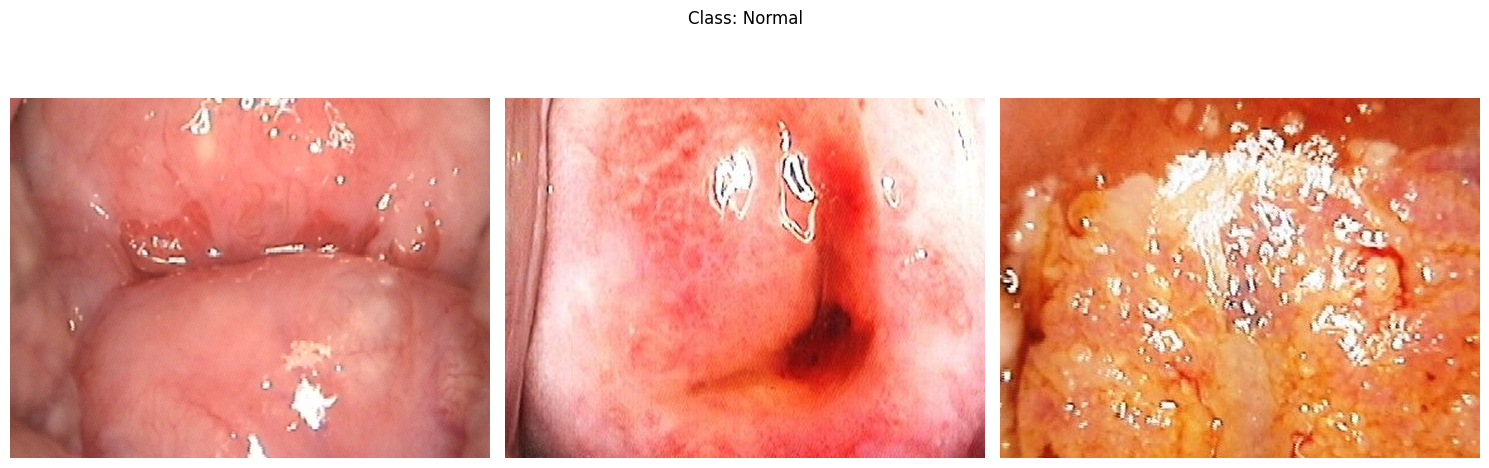

Showing 3 random samples from class 'HSIL'


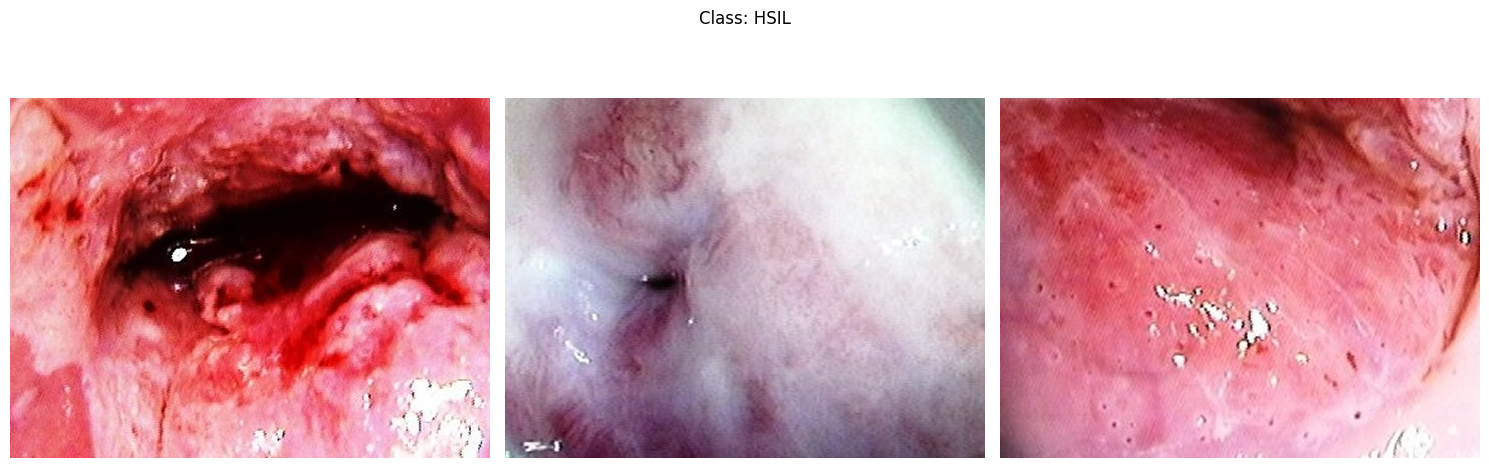

Showing 3 random samples from class 'LSIL'


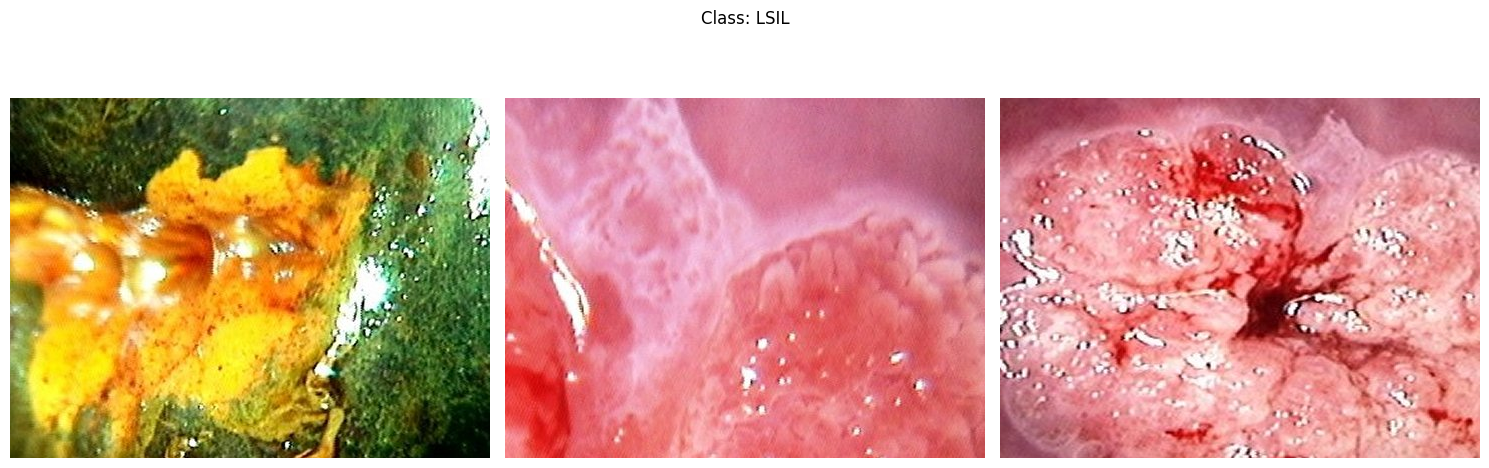

In [3]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import random
def crop_center(img, crop_x=0.6, crop_y=0.6):
    """
    Crop the center of the image.

    Args:
        img (np.array): The input image in RGB format.
        crop_x (float): The percentage of width to retain (between 0 and 1).
        crop_y (float): The percentage of height to retain (between 0 and 1).

    Returns:
        np.array: The cropped image.
    """
    y, x, _ = img.shape
    startx = x // 2 - int(x * crop_x) // 2
    starty = y // 2 - int(y * crop_y) // 2
    endx = startx + int(x * crop_x)
    endy = starty + int(y * crop_y)
    cropped_img = img[starty:endy, startx:endx]
    return cropped_img

def load_images_from_folders(root_folder, subfolders):
    """
    Load images from specified subfolders within the root folder and assign class labels.

    Args:
        root_folder (str): Path to the root folder.
        subfolders (list of str): List of subfolder names to load images from.

    Returns:
        dict: A dictionary where keys are subfolder names (class labels) and values are lists of images.
    """
    images_by_class = {subfolder: [] for subfolder in subfolders}
    for subfolder in subfolders:
        folder_path = os.path.join(root_folder, subfolder)
        print(f"Loading images from {folder_path}...")
        for filename in os.listdir(folder_path):
            img_path = os.path.join(folder_path, filename)
            img = cv2.imread(img_path)
            if img is not None:
                img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                cropped_img = crop_center(img_rgb, crop_x=0.6, crop_y=0.6)
                images_by_class[subfolder].append(cropped_img)
            else:
                print(f"Error: Unable to load image at path '{img_path}'")
        print(f"Loaded {len(images_by_class[subfolder])} images from {subfolder}")
    return images_by_class

def show_random_samples(images_by_class, num_samples=3):
    """
    Display random samples of images from each class.

    Args:
        images_by_class (dict): Dictionary of images categorized by class labels.
        num_samples (int): Number of random samples to display from each class.
    """
    for class_label, images in images_by_class.items():
        print(f"Showing {num_samples} random samples from class '{class_label}'")
        if len(images) == 0:
            print(f"No images found for class '{class_label}'")
            continue
        sampled_images = random.sample(images, min(num_samples, len(images)))
        plt.figure(figsize=(15, 5))
        plt.suptitle(f"Class: {class_label}")
        for i, img in enumerate(sampled_images):
            plt.subplot(1, num_samples, i + 1)
            plt.imshow(img)
            plt.axis('off')
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

# Example usage
root_folder = '/content/drive/MyDrive/colpos'  # Replace with the path to your root folder containing subfolders
subfolders = ['Normal', 'HSIL', 'LSIL']

# Load images and their corresponding class labels
images_by_class = load_images_from_folders(root_folder, subfolders)

# Show random samples from each class
show_random_samples(images_by_class, num_samples=3)


ValueError: num must be an integer with 1 <= num <= 6, not 7

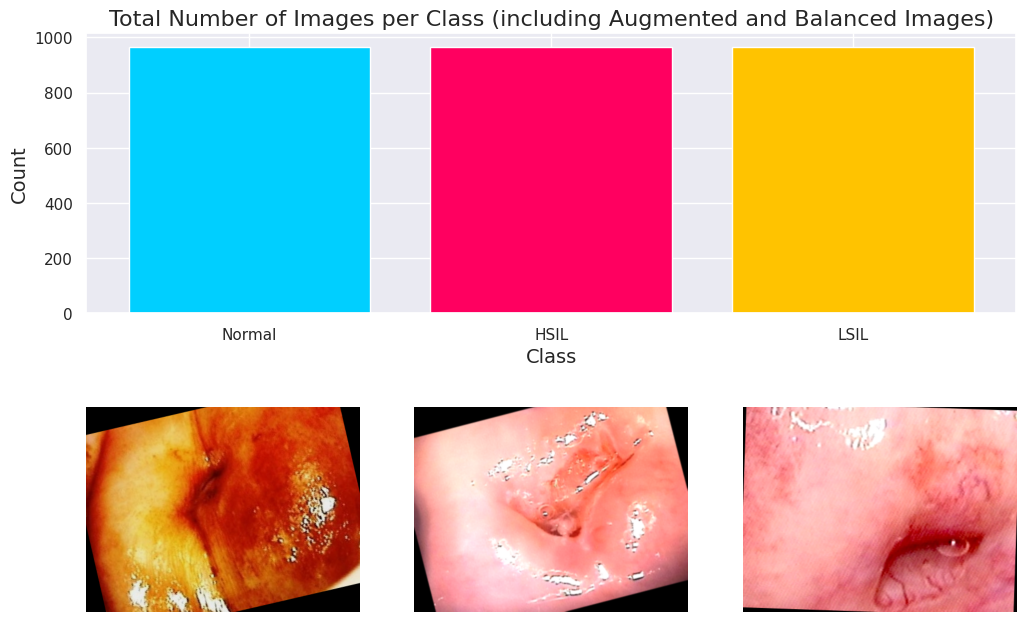

In [4]:
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from imgaug import augmenters as iaa

# Function to augment images
def augment_images(images, num_augmentations=2):
    augmenter = iaa.Sequential([
        iaa.Fliplr(0.5),  # horizontal flips
        iaa.Affine(rotate=(-20, 20)),  # random rotations
        iaa.Multiply((0.8, 1.2)),  # random brightness
        iaa.GaussianBlur(sigma=(0.0, 1.0))  # random blur
    ])
    augmented_images = []
    for img in images:
        for _ in range(num_augmentations):
            aug_img = augmenter(image=img)
            augmented_images.append(aug_img)
    return images + augmented_images  # Include original images as well

# Function to count images
def count_images(images_by_class):
    return {class_label: len(images) for class_label, images in images_by_class.items()}

# Function to oversample images to balance the dataset
def oversample_images(images_by_class):
    image_counts = count_images(images_by_class)
    max_count = max(image_counts.values())

    balanced_images_by_class = {}
    for class_label, images in images_by_class.items():
        num_images = len(images)
        if num_images < max_count:
            augmented_images = augment_images(images, num_augmentations=(max_count - num_images) // num_images)
            balanced_images_by_class[class_label] = images + augmented_images[:max_count - num_images]
        else:
            balanced_images_by_class[class_label] = images
    return balanced_images_by_class

# Function to plot image counts and random samples
def plot_image_counts_and_samples(images_by_class, num_samples=3):
    image_counts = count_images(images_by_class)

    # Plot bar chart of image counts
    sns.set(style="darkgrid")
    plt.figure(figsize=(12, 8))

    # Create bar plot
    plt.subplot(2, 1, 1)
    bars = plt.bar(image_counts.keys(), image_counts.values(), color=['#00CFFF', '#FF0060', '#FFC300'])
    plt.xlabel('Class', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.title('Total Number of Images per Class (including Augmented and Balanced Images)', fontsize=16)

    # Show random samples
    k = 1
    for class_label, images in images_by_class.items():
        sampled_images = random.sample(images, min(num_samples, len(images)))
        for img in sampled_images:
            plt.subplot(2, num_samples, num_samples + k)
            plt.imshow(img)  # Assuming images are in RGB format
            plt.axis('off')
            k += 1

    plt.tight_layout()
    plt.show()

# Example usage
# Assuming images_by_class is already defined and contains cropped images
# images_by_class = {
#     'Normal': [...],  # list of cropped images
#     'HSIL': [...],
#     'LSIL': [...]
# }

# Augment images to increase dataset size
augmented_images_by_class = {}
for class_label, images in images_by_class.items():
    augmented_images_by_class[class_label] = augment_images(images, num_augmentations=2)

# Oversample images to balance the dataset
balanced_images_by_class = oversample_images(augmented_images_by_class)

# Plot image counts and random samples
plot_image_counts_and_samples(balanced_images_by_class, num_samples=3)



In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# Define constants
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Assuming images_by_class contains your balanced images
# Flatten the dictionary to get image arrays and their labels
images = []
labels = []
for label, img_list in balanced_images_by_class.items():
    images.extend(img_list)
    labels.extend([label] * len(img_list))

# Convert lists to numpy arrays
images = np.array(images)
labels = np.array(labels)

# Encode labels
label_to_index = {label: index for index, label in enumerate(set(labels))}
index_to_label = {index: label for label, index in label_to_index.items()}
labels = np.array([label_to_index[label] for label in labels])

# Split data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, stratify=labels, random_state=42)

# ImageDataGenerator for data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE)
val_generator = val_datagen.flow(X_val, y_val, batch_size=BATCH_SIZE)


In [6]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

# Define the directory and the classes
data_dir = '/content/drive/MyDrive/colpos'
classes = ['Normal', 'HSIL', 'LSIL']

# Initialize lists to hold the images and labels
images = []
labels = []

# Load the images and labels
for label, class_name in enumerate(classes):
    class_dir = os.path.join(data_dir, class_name)
    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)
        img = cv2.imread(img_path)
        if img is not None:
            images.append(img)
            labels.append(label)

# Convert lists to numpy arrays
images = np.array(images)
labels = np.array(labels)


In [ ]:
# Split the data
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, stratify=labels, random_state=42)

# Normalize the images
X_train = X_train / 255.0
X_val = X_val / 255.0


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the ImageDataGenerators
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator()

# Create the generators
train_generator = train_datagen.flow(
    X_train, y_train,
    batch_size=32
)

val_generator = val_datagen.flow(
    X_val, y_val,
    batch_size=32
)


In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Load the base model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]))

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(classes), activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(train_generator, validation_data=val_generator, epochs=10)


In [ ]:
from tensorflow.keras.applications import InceptionResNetV2

# Load the base model
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]))

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(classes), activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(train_generator, validation_data=val_generator, epochs=10)


# New Section